# Numerical Benchmarks

In [7]:
import sys
sys.path.insert(0, '../../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from quantum_tools import *
from experimental import *
from spam import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Recover SPAM and Map

### Generate True Model, Full POVM and Inital

In [8]:
def generate_spam_benchmark(n=3, c1=1, c2=1):
    d = 2**n
    spam_target = SPAM(d=d)

    init_target = c1*init_ideal(d) + (1-c1)*spam_target.init
    povm_target = c2*povm_ideal(d) + (1-c2)*spam_target.povm

    spam_target = SPAM(d=d,
                       init = init_target,
                       povm = povm_target)
    
    return spam_target


def generate_spam_data(spam_target, N_spam=None, noise=0):
    n = spam_target.n
    inputs_spam, _ = generate_pauliInput_circuits(n, N_spam)
    N_spam = inputs_spam.shape[0]

    state = tf.repeat(spam_target.init[None,:,:], N_spam, axis=0)
    state = apply_unitary(state, inputs_spam)
    targets_spam = measurement(state, povm = spam_target.povm)

    #add noise
    targets_spam = add_noise_to_probs(targets_spam, noise=noise)
    return inputs_spam, targets_spam


def generate_map_data(channel_target, spam_target, N_map=None, noise=0):
    n = channel_target.n
    inputs_map, _ = generate_pauli_circuits(n = n, 
                                            circuit_target=None,  
                                            trace=False,
                                            N=N_map)
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    state = tf.repeat(tf.expand_dims(spam_target.init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis, spam_target.povm)
    
    return inputs_map, targets_map


def povm_fidelity(spam_a, spam_b):
    d = spam_a.d
    povm_a, povm_b = spam_a.povm, spam_b.povm
    ab = tf.matmul(povm_a, povm_b)
    ab_sqrt = tf.linalg.sqrtm(ab)
    fidelity = tf.math.reduce_sum(tf.linalg.trace(ab_sqrt))/d
    return fidelity


def model_pipeline(channel_target, noise, N_map=2000):
    # Make Benchmark
    #################################################################################
    n = 3
    d = 2**n
    
    spam_target = generate_spam_benchmark(n=n, c1=0.8, c2=0.8)
    inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

    inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=N_map, noise=noise)
    #################################################################################

    # Fit Models
    #################################################################################
    spam_model = SPAM(d=d,
                      use_corr_mat=True,
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))

    spam_model.pretrain(targets = [init_ideal(d), povm_ideal(d)],
                        num_iter = 300,
                        verbose = False,
                        )

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 2000,
                     verbose = False,
                    )

    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                               rank = d**2,
                                               spam = spam_model,
                                              ),
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = channel_fidelity_loss),
                           )

    model.train(inputs = inputs_map,
                targets = targets_map,
                inputs_val = None,
                targets_val = [channel_target],
                num_iter = 2000,
                N = 500,
                )
    #################################################################################

    return model

## Fit Models

In [9]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

channel_target1 = CompactLindbladMap(d, 2, 1, 0.1)
model1 = model_pipeline(channel_target1, noise=1/100)

channel_target2 = CompactLindbladMap(d, 16, 10000, 0.001)
model2 = model_pipeline(channel_target2, noise=1/100)

channel_target3 = CompactLindbladMap(d, 16, 100, 0.001)
model3 = model_pipeline(channel_target3, noise=1/100)

channel_target4 = CompactLindbladMap(d, 8, 1, 0.01)
model4 = model_pipeline(channel_target4, noise=1/100)

  0%|          | 0/2000 [00:00<?, ?it/s]

0.0023473060878363926


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.08766725008272647
None -0.350305988214192
None -0.6557560691989885
None -0.7958542843022133
None -0.8571779521130622
None -0.8889714126976892
None -0.9082857535073472
None -0.9207778782611753
None -0.9295167467474996
None -0.9357430972632791
None -0.9403165612037765
None -0.9439419991400906
None -0.9467026671937877
None -0.9488060869267471
None -0.9505436177533597
None -0.9520700357104095
None -0.9531218834512454
None -0.9540574404428248
None -0.954813846203319
None -0.9554806197372474
None -0.9559798352073913


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0023370554104252335


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.24120463509324558
None -0.6950464596235316
None -0.8879672817345895
None -0.9084658072612855
None -0.9134577160385224
None -0.9154498685531299
None -0.9159418208440806
None -0.9155617769359649
None -0.9143740404299422
None -0.9129942312019497
None -0.9112979473076459
None -0.9095020398915116
None -0.9076700326768001
None -0.905810033126624
None -0.9039558560959989
None -0.9021535734020459
None -0.9003771081818083
None -0.898471047177232
None -0.8967096284243469
None -0.8952338713294365
None -0.893633210877616


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0020799567731921787


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.1429426017272639
None -0.4072244946002416
None -0.7331780768704677
None -0.8139678601031203
None -0.847286350445391
None -0.8693409009505177
None -0.8845899938730793
None -0.8954262153168008
None -0.903542681476477
None -0.9093541569505489
None -0.9140355729781615
None -0.917431499946045
None -0.9200884615356587
None -0.922009052584419
None -0.9237252949634859
None -0.9248306332231443
None -0.9259086867072599
None -0.9263918405406121
None -0.9267173428676408
None -0.9269933746698799
None -0.9274633268301041


  0%|          | 0/2000 [00:00<?, ?it/s]

0.00234200091668231


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.3598629730893975
None -0.5851927200212269
None -0.7584412459448822
None -0.8364699221743648
None -0.8750420153375547
None -0.8973255895266126
None -0.9116919343254847
None -0.9216083644954336
None -0.9287571195930772
None -0.934240003877129
None -0.9384947302214279
None -0.9417701949654642
None -0.9444267122479422
None -0.9465482158944796
None -0.948283924544238
None -0.9496802134491864
None -0.9507385971404098
None -0.9516504358809301
None -0.9523294922924701
None -0.9528684371556653
None -0.9533497725905261


In [11]:
spectrum_target1 = channel_spectrum(channel_target1)
spectrum_target2 = channel_spectrum(channel_target2)
spectrum_target3 = channel_spectrum(channel_target3)
spectrum_target4 = channel_spectrum(channel_target4)

spectrum_model1 = channel_spectrum(model1.channel)
spectrum_model2 = channel_spectrum(model2.channel)
spectrum_model3 = channel_spectrum(model3.channel)
spectrum_model4 = channel_spectrum(model4.channel)

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


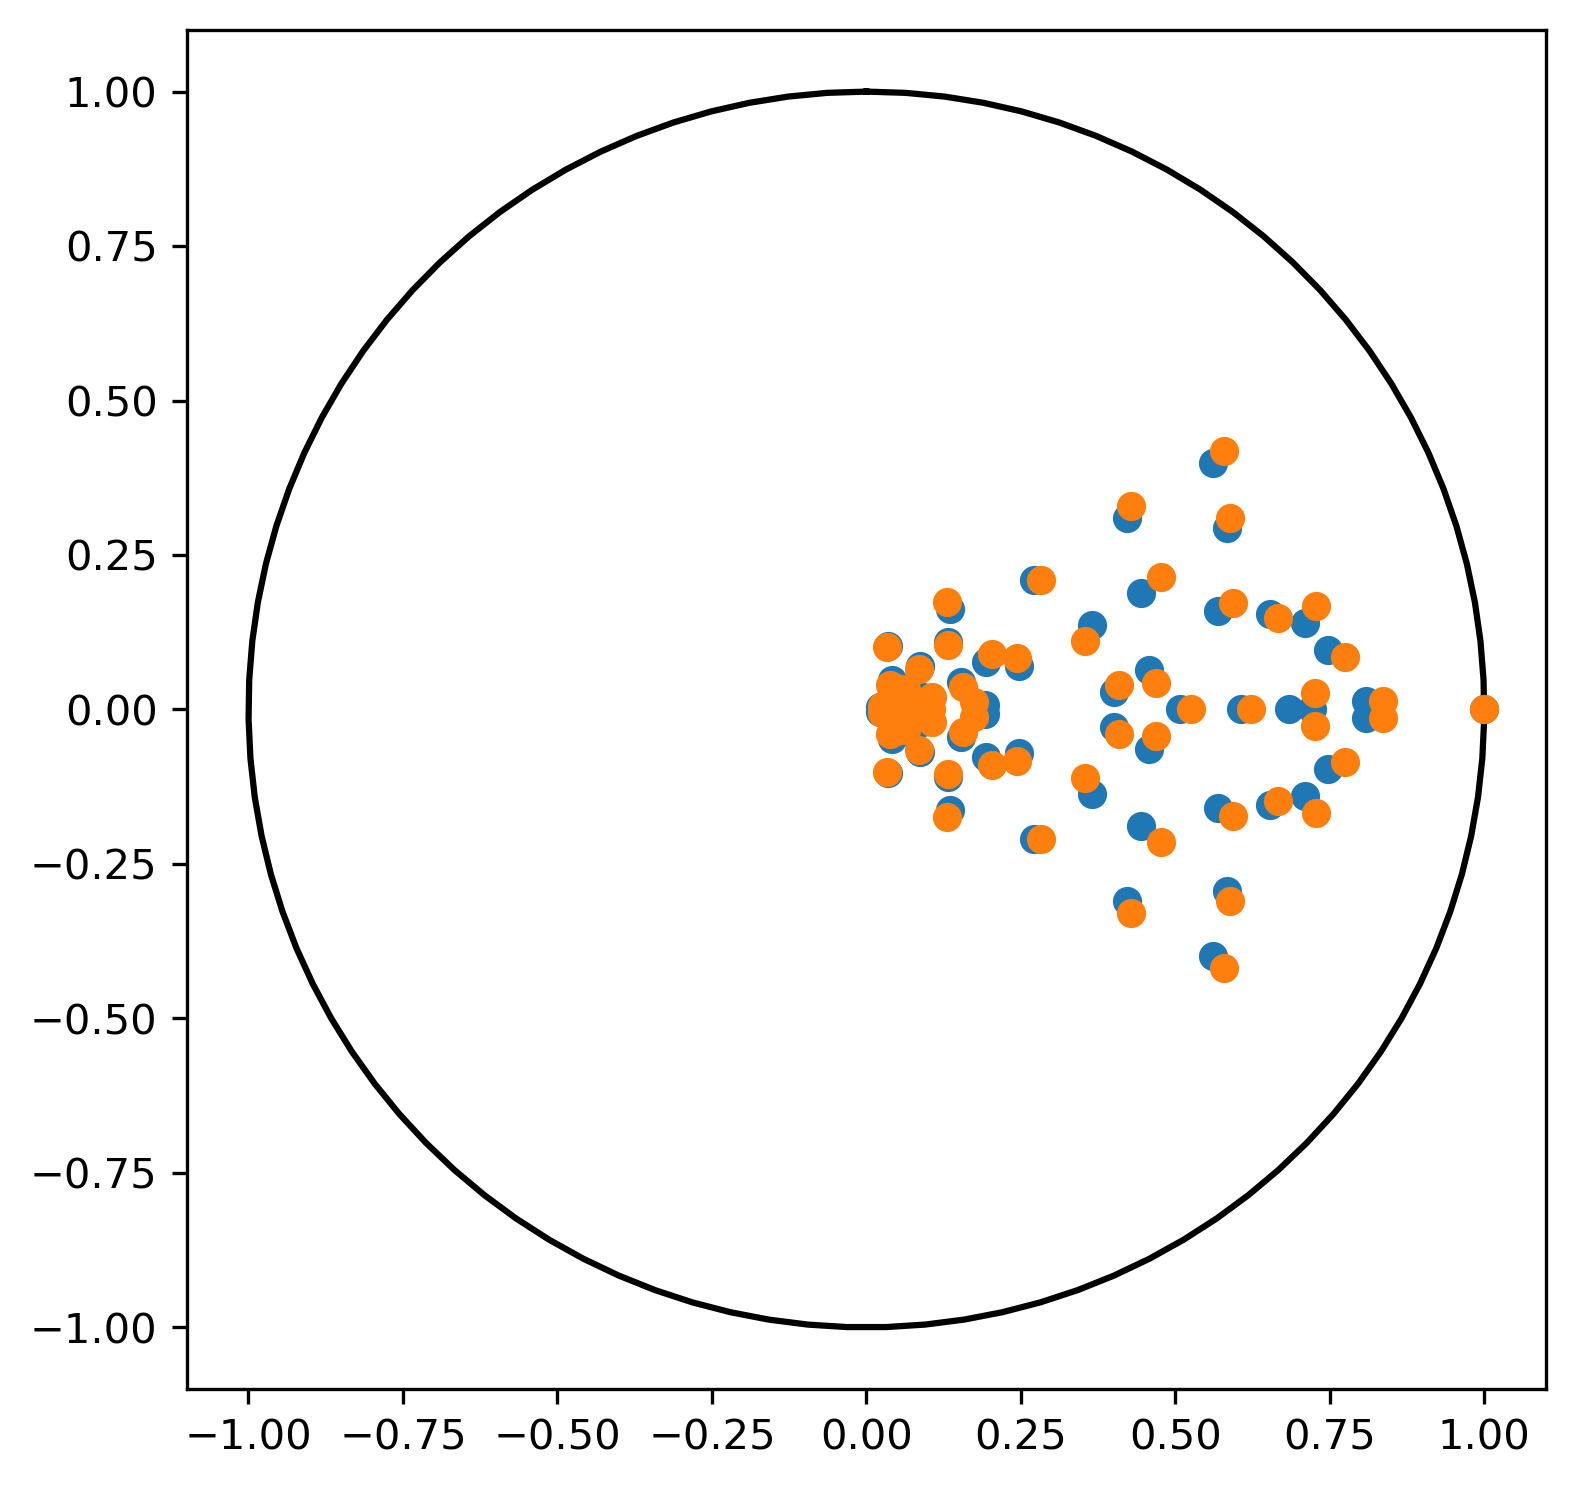

In [12]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.plot(spectrum_target1[:,0], spectrum_target1[:,1], "o")
plt.show()

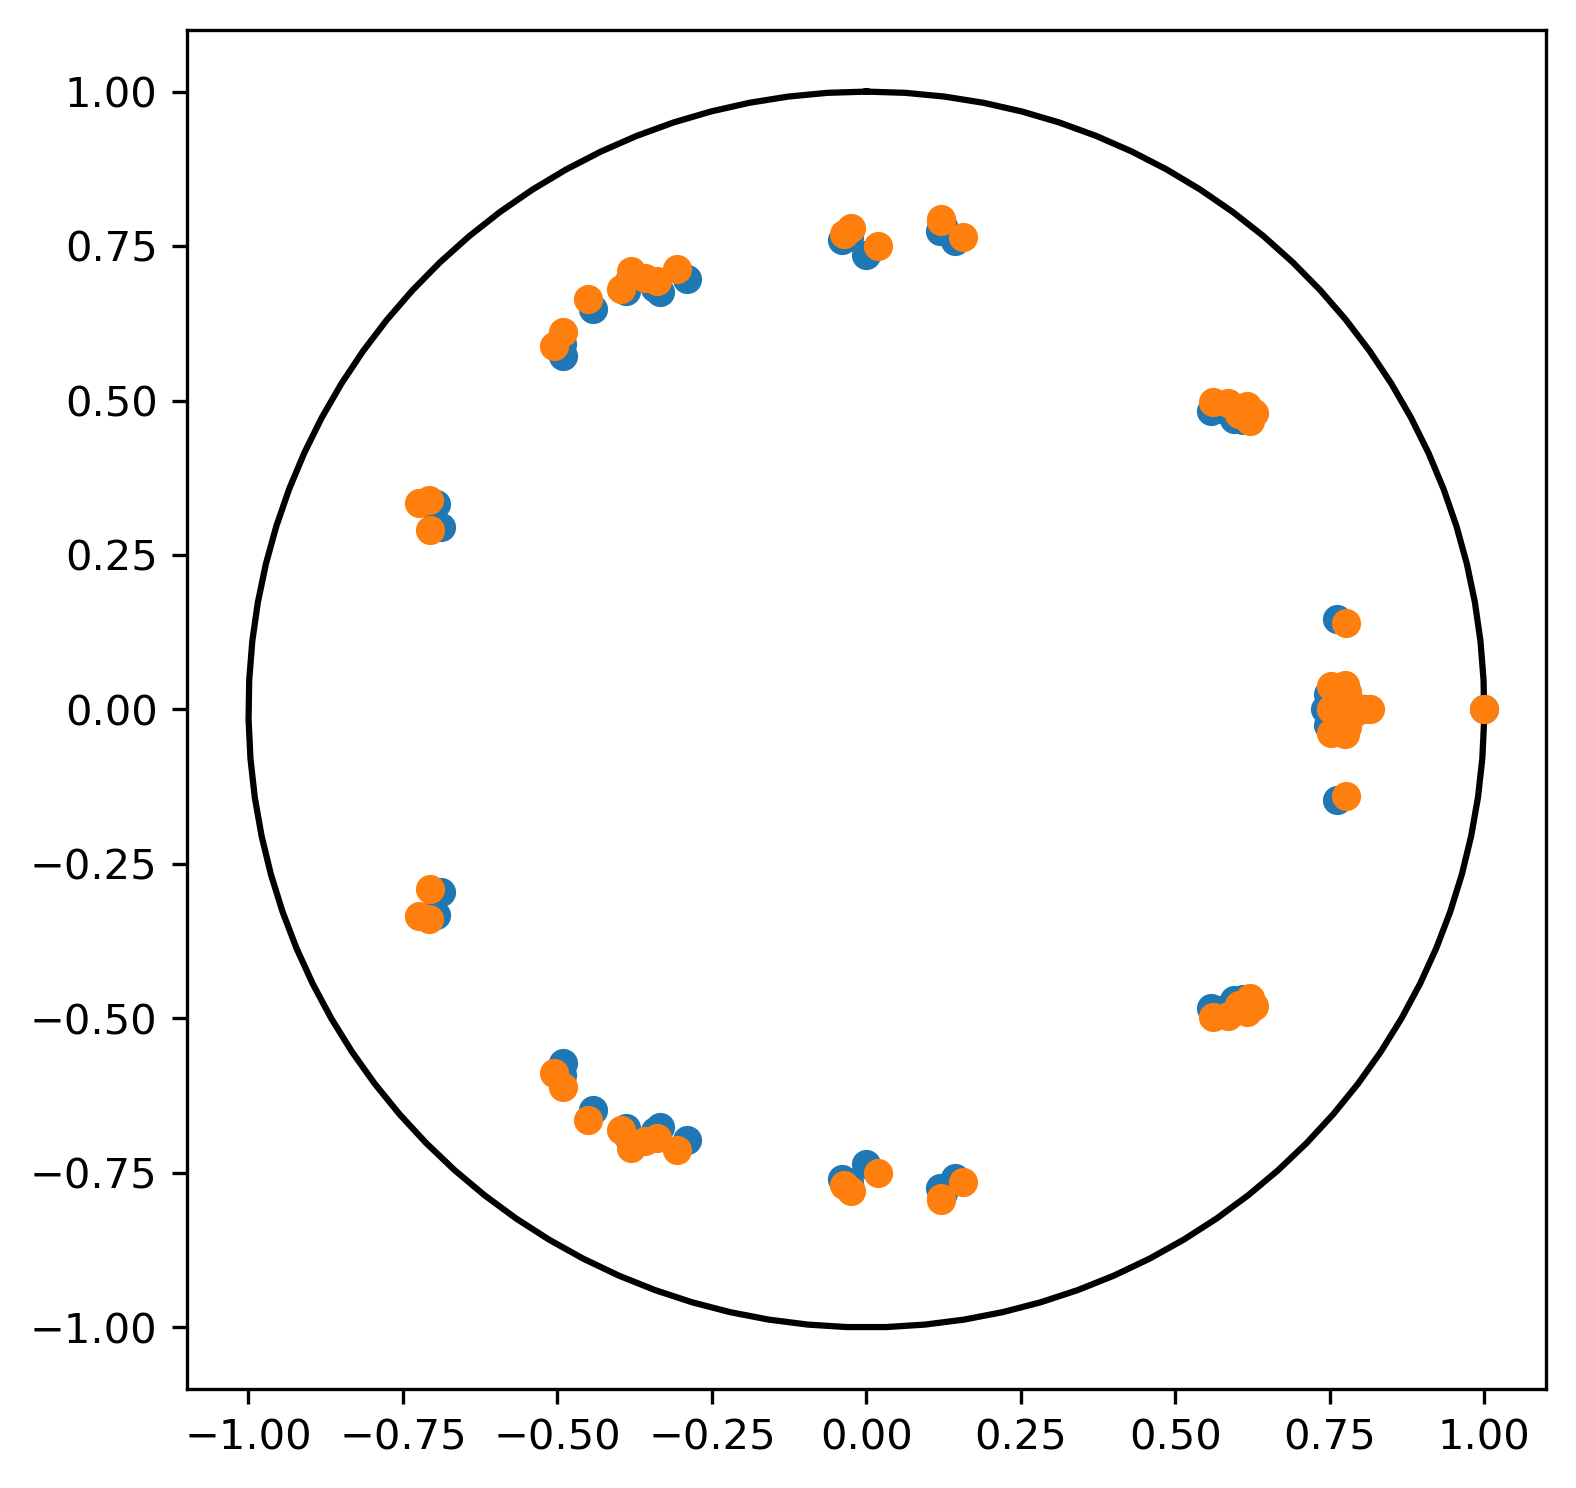

In [13]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
plt.plot(spectrum_target2[:,0], spectrum_target2[:,1], "o")
plt.show()

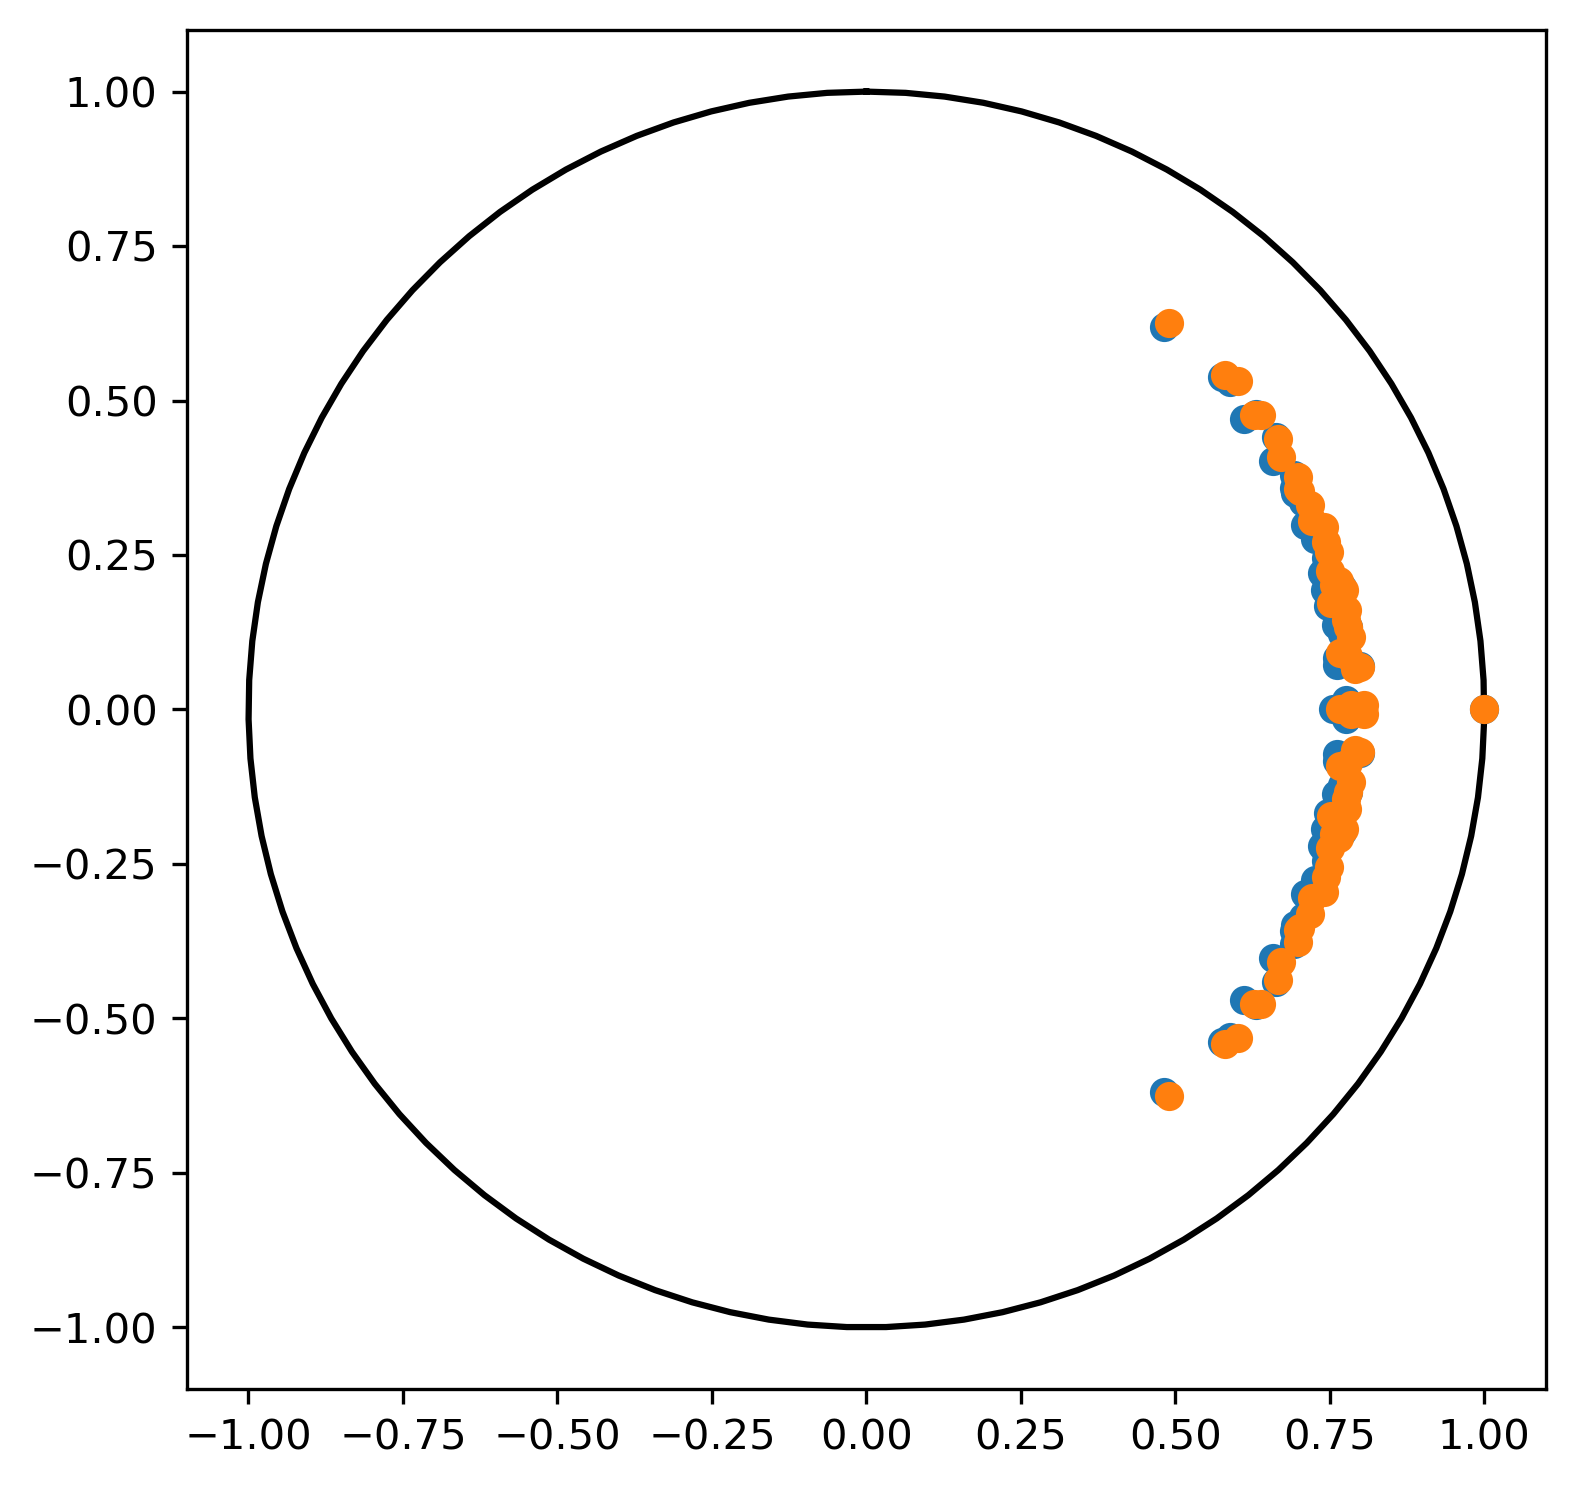

In [14]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.plot(spectrum_target3[:,0], spectrum_target3[:,1], "o")
plt.show()

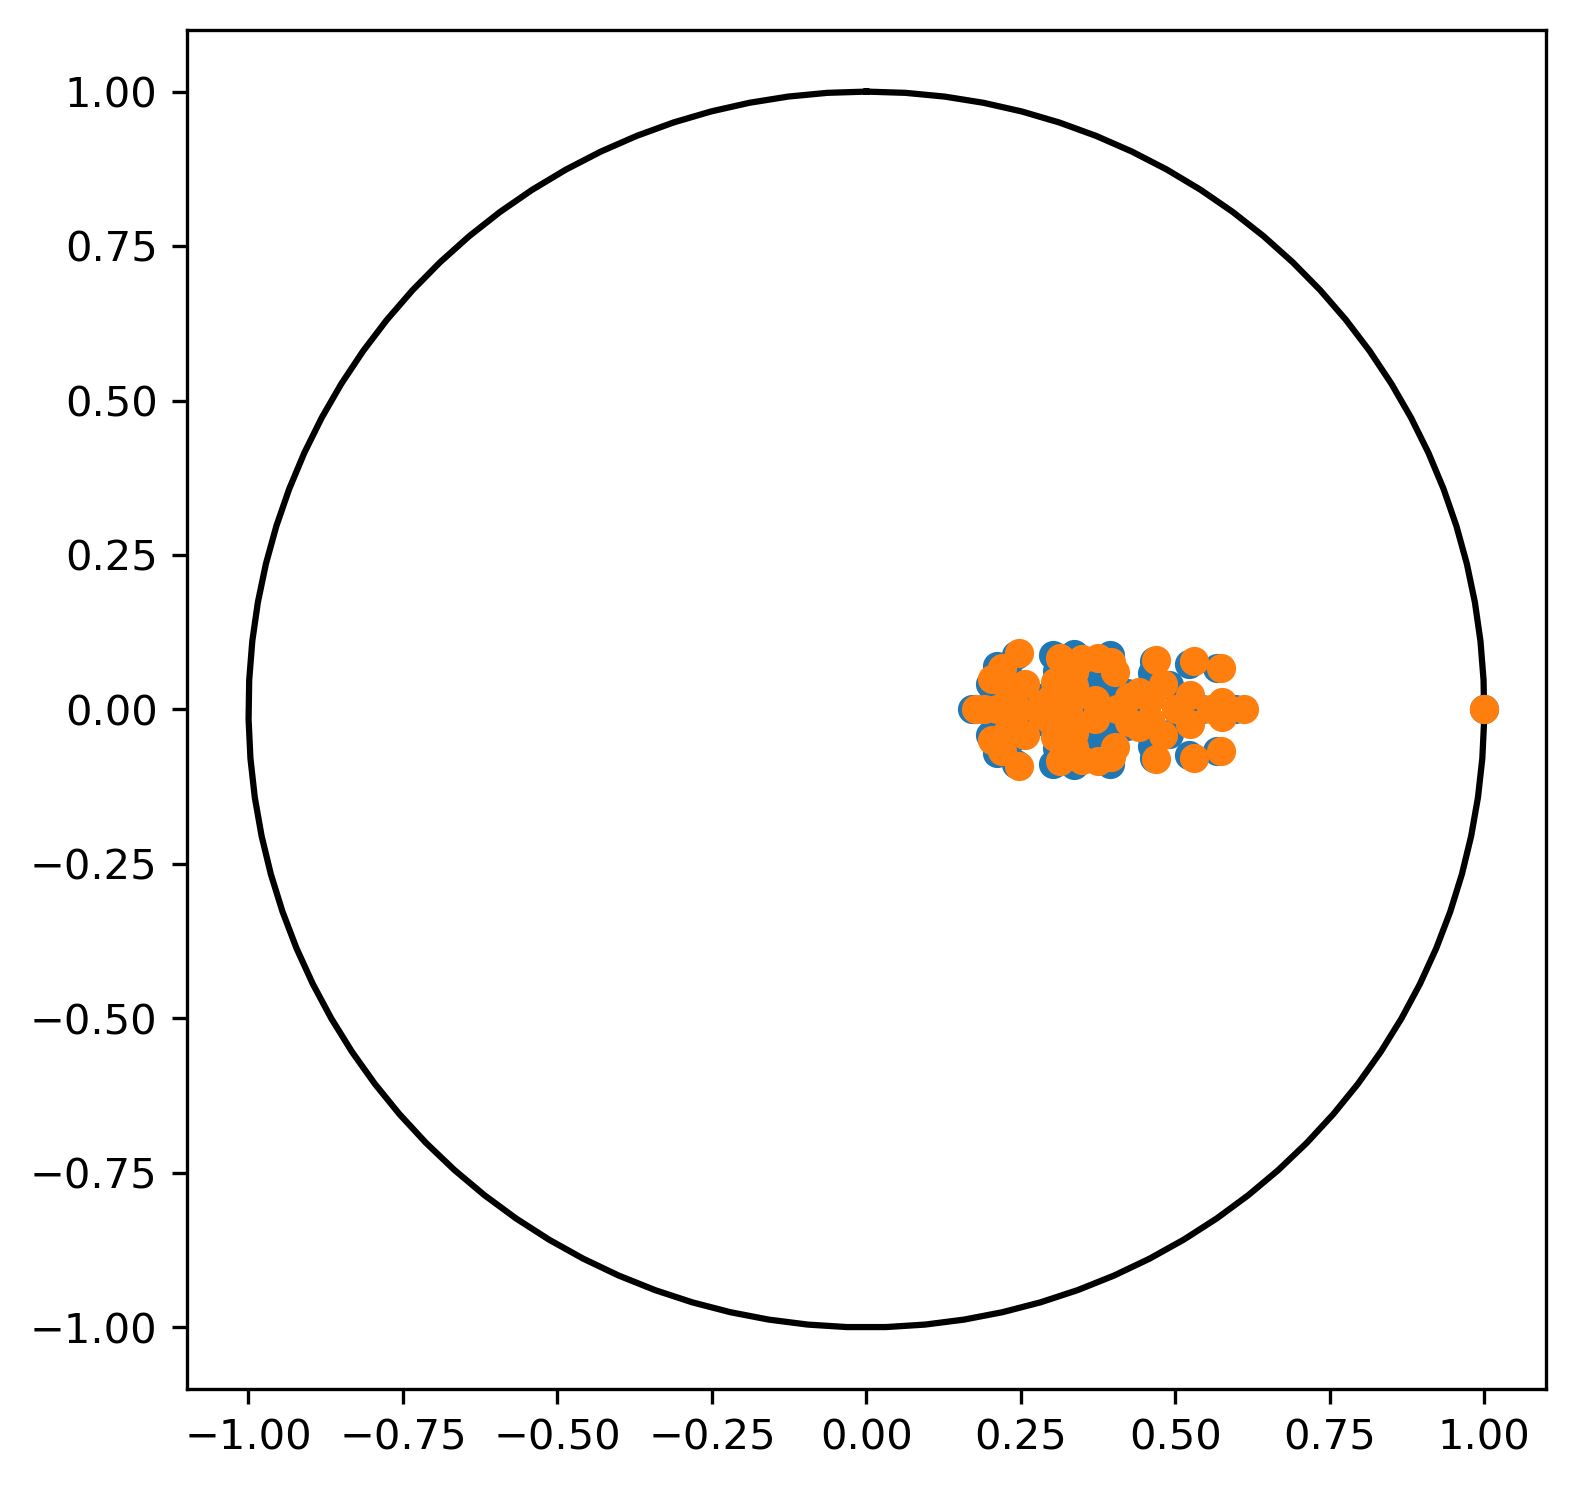

In [15]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_model4[:,0], spectrum_model4[:,1], "o")
plt.plot(spectrum_target4[:,0], spectrum_target4[:,1], "o")
plt.show()

## Sample and Noise Sensitivity

In [36]:
n = 3
d = 2**n

channel_target = CompactLindbladMap(d, 2, 1, 0.1)
model_ns1 = model_pipeline(channel_target, noise=0.1, N_map=365)
model_ns2 = model_pipeline(channel_target, noise=0.01, N_map=1458)
model_ns3 = model_pipeline(channel_target, noise=0.0, N_map=5832)

  0%|          | 0/2000 [00:00<?, ?it/s]

0.05305255321013056


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.09976551137038538
None -0.37453649486015683
None -0.63558413902765
None -0.7549317980145784
None -0.8128208842293305
None -0.8448474931874754
None -0.8643058535302734
None -0.8769258911212299
None -0.8854930734775682
None -0.8915006010580244
None -0.8958124714992548
None -0.8989594607195956
None -0.901283535430142
None -0.903013515193905
None -0.904307145502865
None -0.905275785616217
None -0.9059996321362701
None -0.9065374731475768
None -0.9069330820819065
None -0.9072194939990221
None -0.9074219083552425


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0019998632432423726


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.10016221825805785
None -0.38743653955235097
None -0.6902058353078301
None -0.8209797237253046
None -0.8777245005817877
None -0.9072275774331611
None -0.9246442677171933
None -0.935723545873606
None -0.9432766816670265
None -0.9485827523455251
None -0.9524353090108693
None -0.9553063310246244
None -0.9574166223485402
None -0.9589960984699228
None -0.9602885655882284
None -0.9612392827682562
None -0.9619331734279971
None -0.9625318272562976
None -0.9630146927077637
None -0.963496399557261
None -0.9637355640094336


  0%|          | 0/2000 [00:00<?, ?it/s]

0.0016422986048597492


  0%|          | 0/2000 [00:00<?, ?it/s]

None -0.10183606658581042
None -0.3844726480950123
None -0.6939053408434575
None -0.825033452649888
None -0.8808326687898667
None -0.9099106225932766
None -0.9271046417773917
None -0.9382086170462869
None -0.9456653694239731
None -0.9510441029399077
None -0.9551220754772873
None -0.9580521910338976
None -0.9601894419695215
None -0.9620031499844492
None -0.9633806355181851
None -0.9643659954123878
None -0.9650520142750113
None -0.9655994423021443
None -0.9663404439089892
None -0.9667471545544926
None -0.9672178503406758


In [38]:
spectrum_target = channel_spectrum(channel_target)

spectrum_model1 = channel_spectrum(model_ns1.channel)
spectrum_model2 = channel_spectrum(model_ns2.channel)
spectrum_model3 = channel_spectrum(model_ns3.channel)

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\2171647831.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C502CFC610> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth"], loc="lower left")


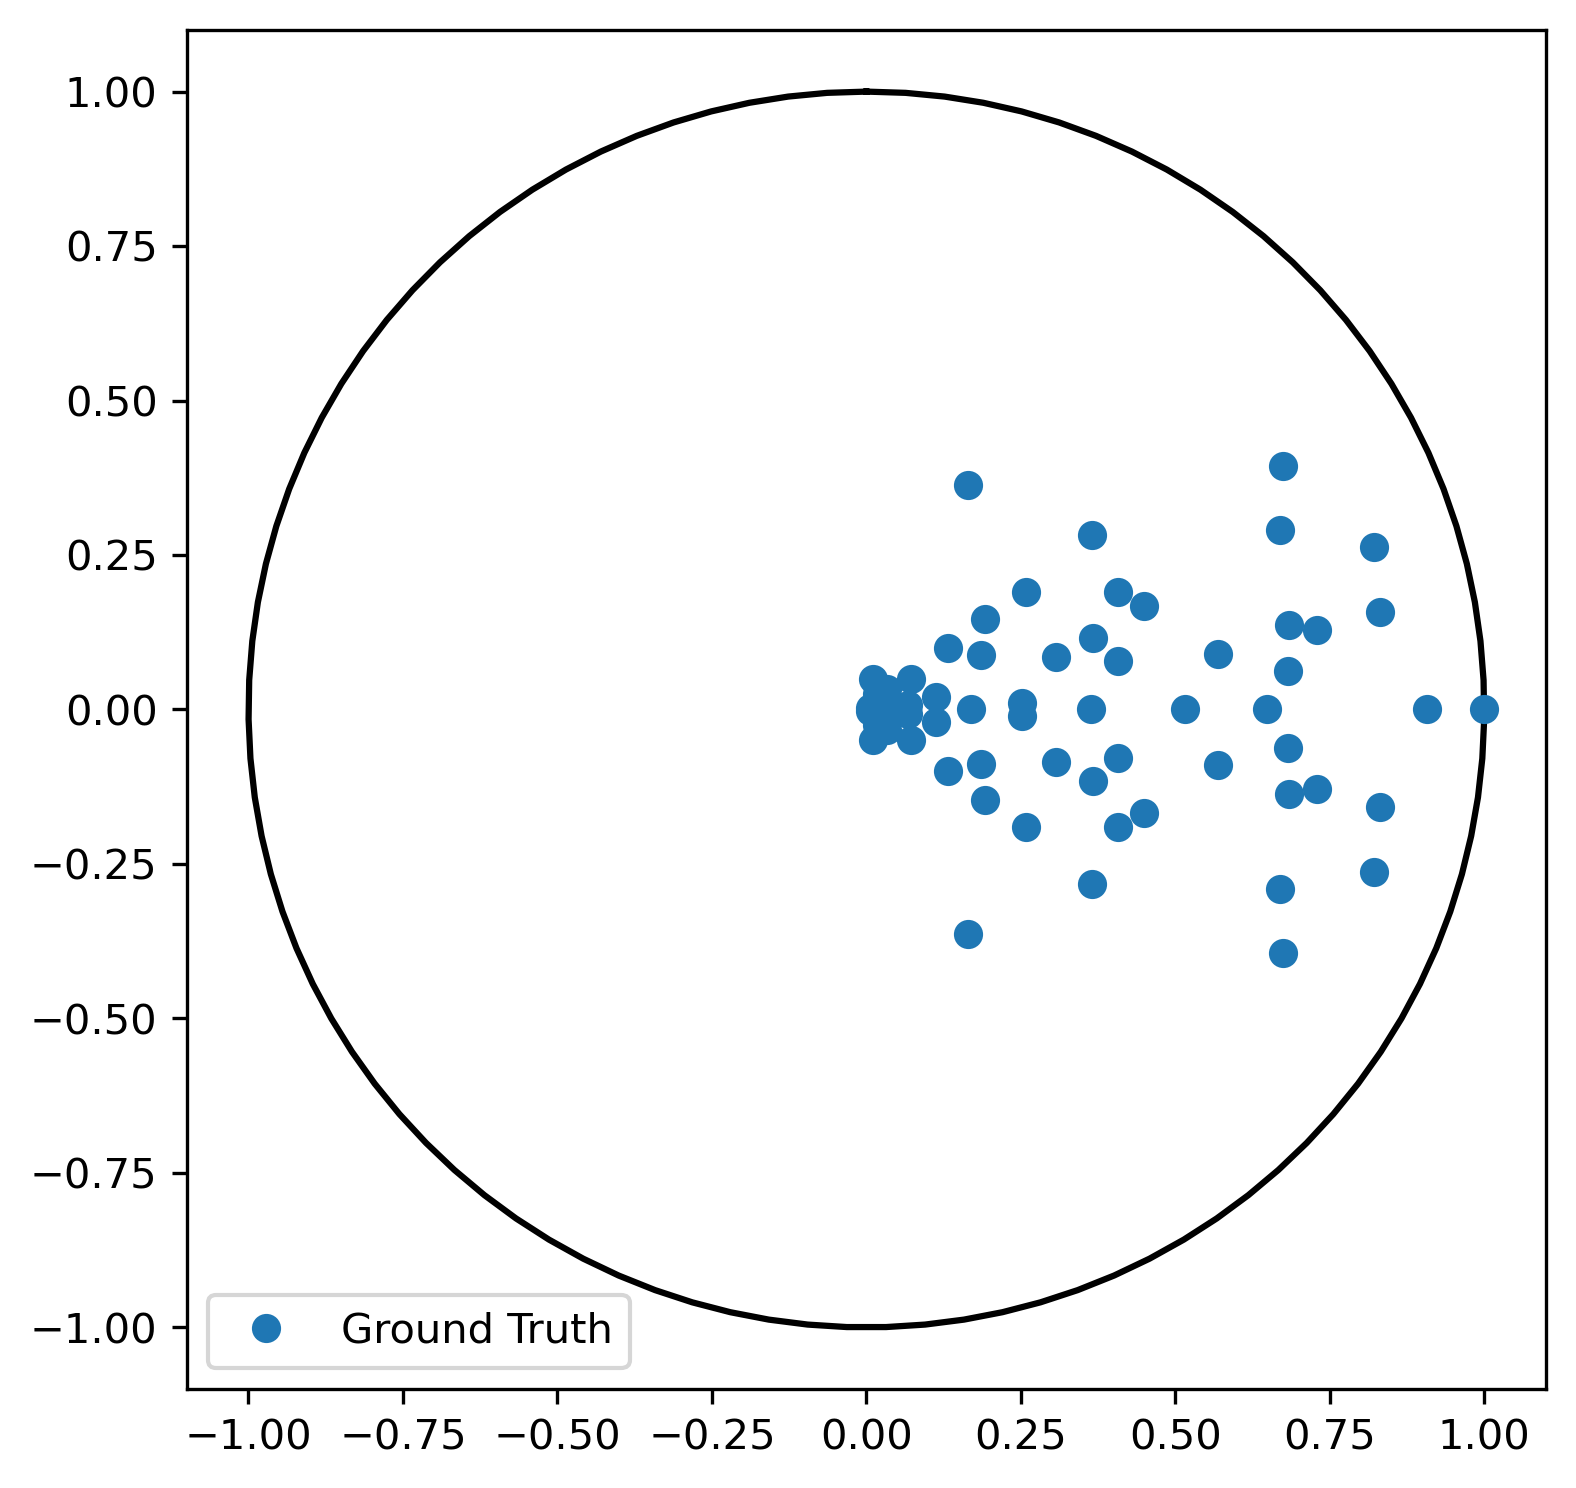

In [49]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
#plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
#plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Ground Truth"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\3107633130.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C50931B1C0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth", "Shots=$10^2$, 1/16 Samples"], loc="lower left")


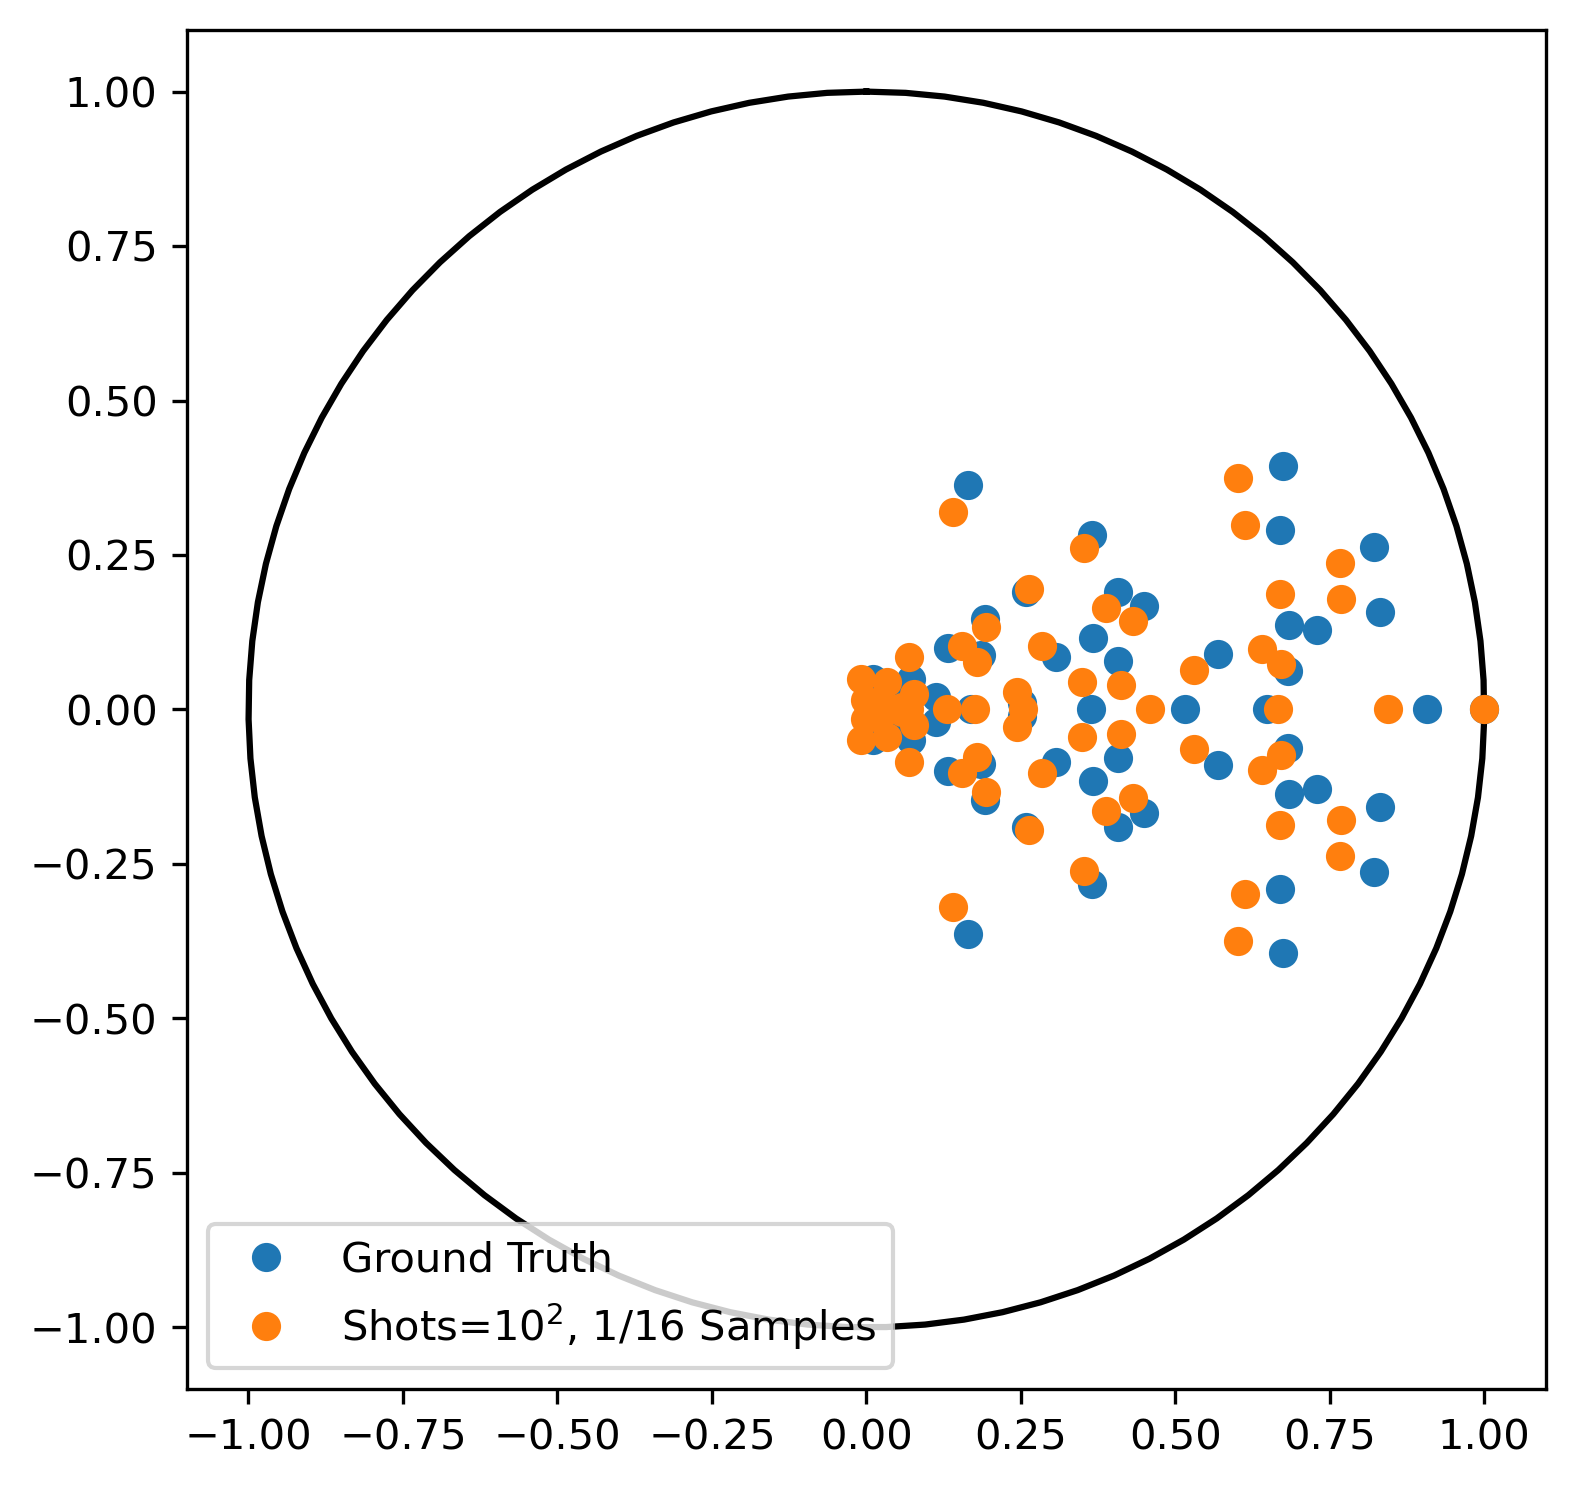

In [52]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
#plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Ground Truth", "Shots=$10^2$, 1/16 Samples"], loc="lower left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\366687958.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C50A4120B0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth", "Shots=$10^2$, 1/16 Samples", "Shots=$10^4$, 1/4 Samples"], loc="bottom left")


ValueError: 'bottom left' is not a valid value for loc; supported values are 'best', 'upper right', 'upper left', 'lower left', 'lower right', 'right', 'center left', 'center right', 'lower center', 'upper center', 'center'

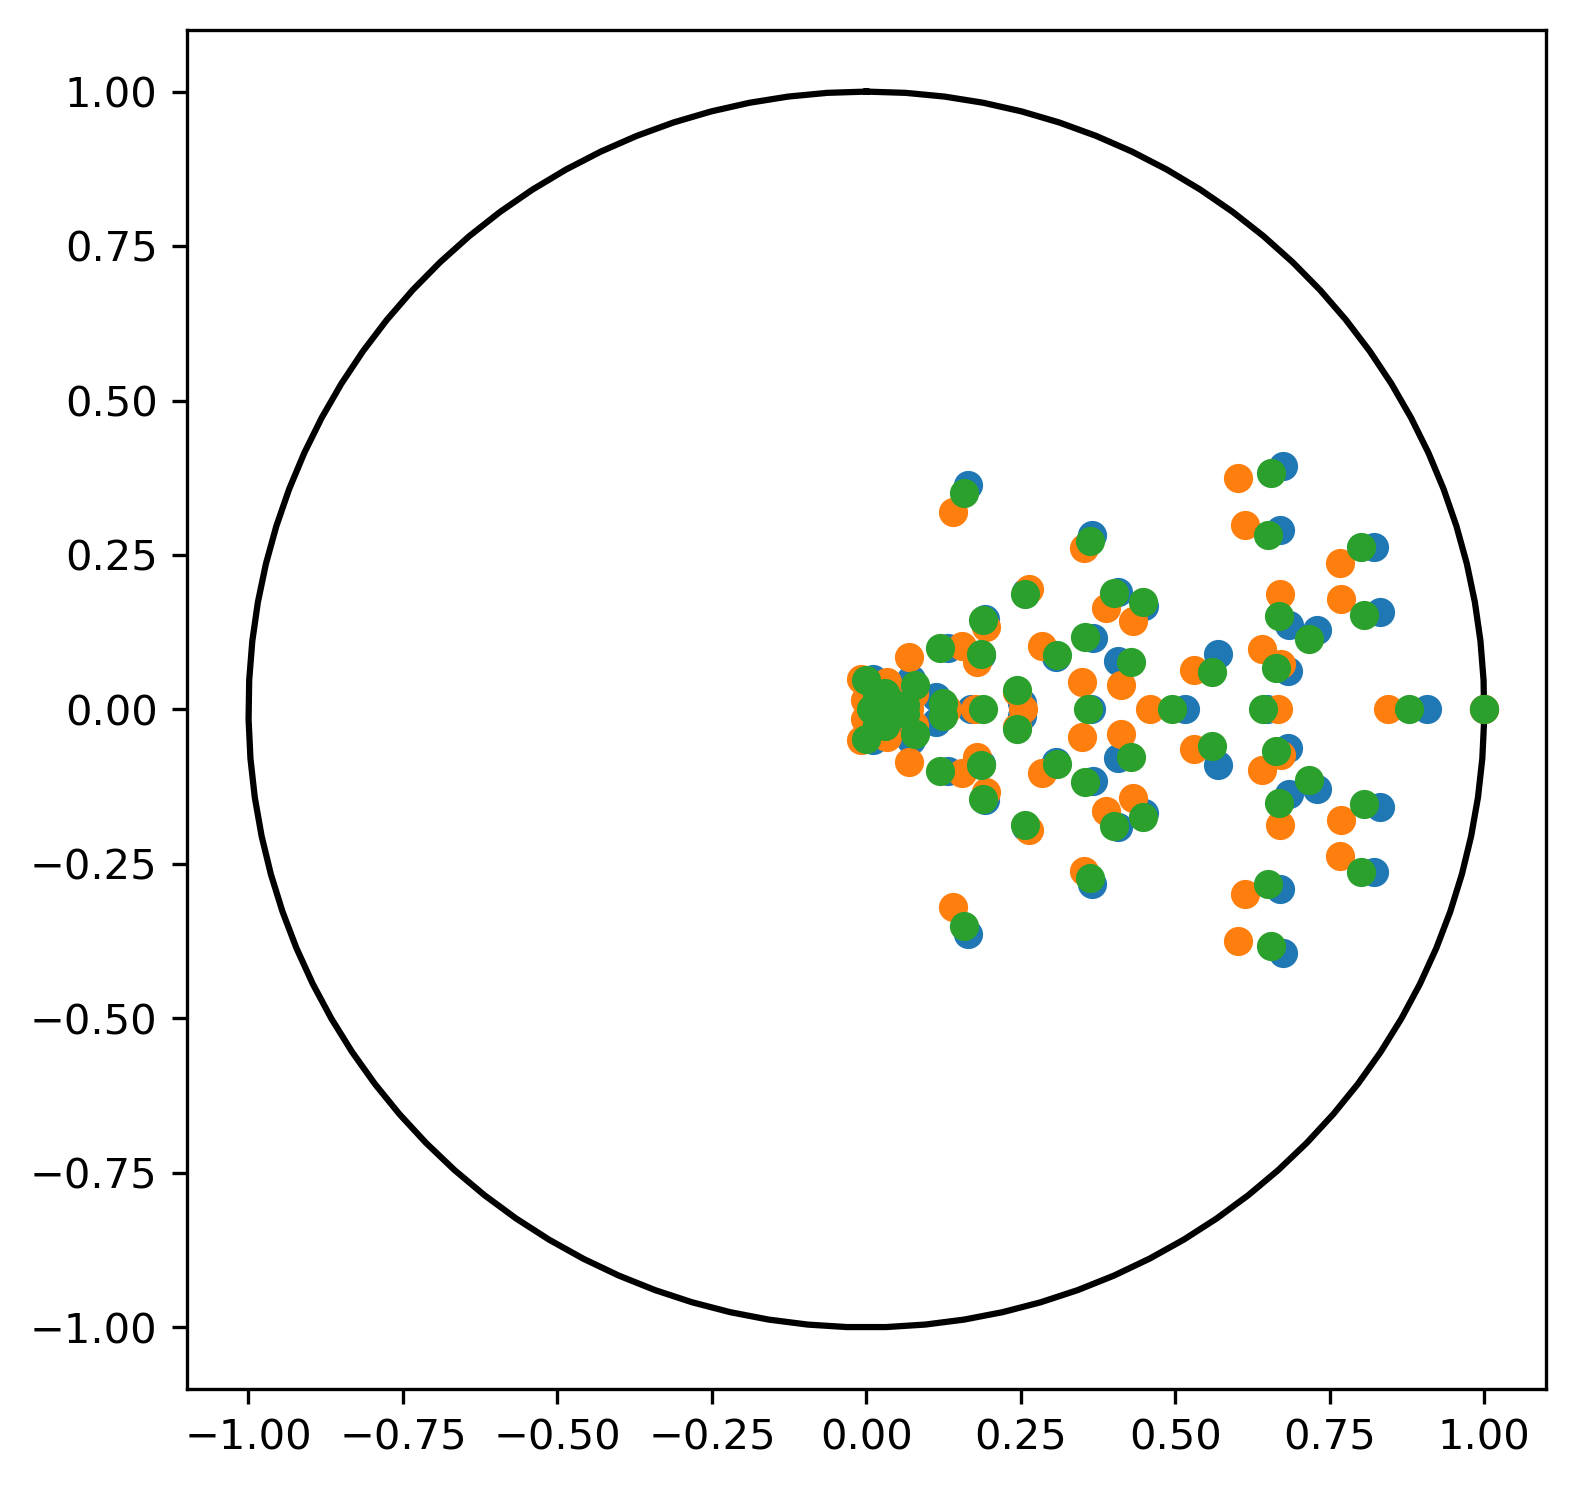

In [53]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
#plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Ground Truth", "Shots=$10^2$, 1/16 Samples", "Shots=$10^4$, 1/4 Samples"], loc="bottom left")
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_4564\2212686547.py:12: UserWarning: The handle <matplotlib.lines.Line2D object at 0x000001C50A4B69E0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_","Ground Truth", "Shots=$10^2$, 1/16 Samples", "Shots=$10^4$, 1/4 Samples", "Shots=$\infty$, All Samples"], loc="lower left")


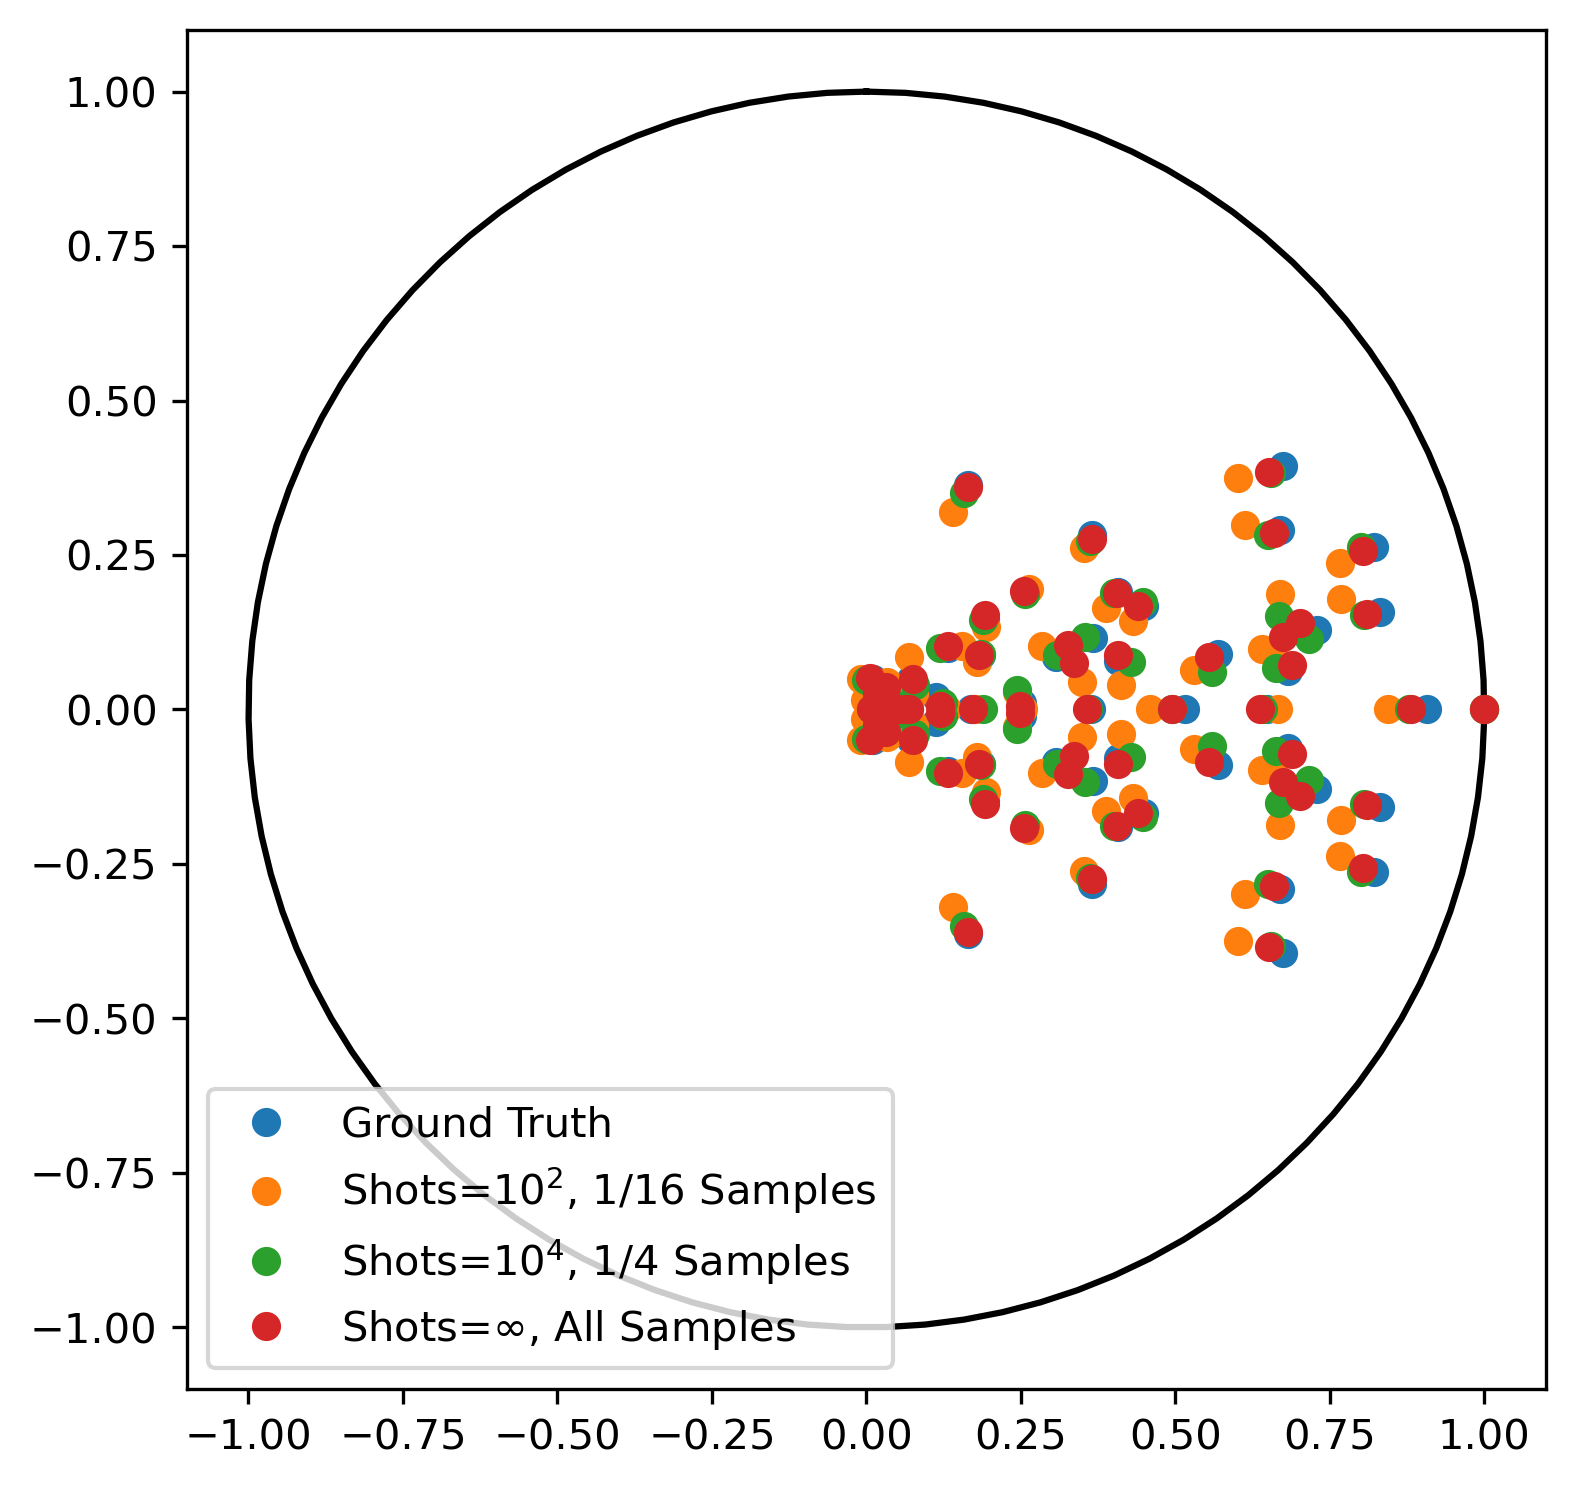

In [54]:
t = np.linspace(0, 2*np.pi, 100)
circle = [np.sin(t), np.cos(t)]
fig = plt.figure(figsize=(6,6), dpi = 300, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
ax.set_aspect(1)
plt.plot(*circle, "k")

plt.plot(spectrum_target[:,0], spectrum_target[:,1], "o")
plt.plot(spectrum_model1[:,0], spectrum_model1[:,1], "o")
plt.plot(spectrum_model2[:,0], spectrum_model2[:,1], "o")
plt.plot(spectrum_model3[:,0], spectrum_model3[:,1], "o")
plt.legend(["_","Ground Truth", "Shots=$10^2$, 1/16 Samples", "Shots=$10^4$, 1/4 Samples", "Shots=$\infty$, All Samples"], loc="lower left")
plt.show()